Consider the following Poisson equation with Dirichlet boundary condition over a bounded domain $\Omega\subset\mathbb{R}^d$
\begin{equation}
\begin{cases}
-\Delta u(x) = f(x), & \;\text{in} \;\Omega,\\
u(x) = g(x), & \; \text{on} \; \partial\Omega, 
\end{cases}
\end{equation}
where $f, g$ are given functions. 
Denote $u(x;\theta)$   the approximate NN solution with the set of parameters  $\theta$  in the NN. The collection of all $u(x;\theta)$ is used as the trial space.

## 1. Setup

In [14]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LogNorm
from math import *
import time
import copy
import itertools
from tqdm import *
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

torch.set_default_tensor_type('torch.DoubleTensor')

## 2. Hyperparameter

In [15]:
# %%
dimension_list = list(range(1,4,1))
net_width_list = list(range(25, 175, 25))


## 3. Neural Architecture

In [16]:
# %%
# activation function
def activation(x):
    return x * torch.sigmoid(x)

# %%
# build ResNet with one blocks
class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width):
        super(Net,self).__init__()
        self.layer1 = torch.nn.Linear(input_width, layer_width)
        self.layer2 = torch.nn.Linear(layer_width, layer_width)
        self.layer3 = torch.nn.Linear(layer_width, layer_width)
        self.layer4 = torch.nn.Linear(layer_width, 1)
        self.initialize_weights()
    def forward(self,x):
        y = activation(self.layer1(x))
        y = activation(self.layer3(activation(self.layer2(y)))) # residual block 1
        output = self.layer4(y)
        return output
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        # print(self)
        print('Total number of parameters: %d' % num_params)

# %%
#net = Net(input_width,layer_width)


The experiment define the neural network $\mathcal{N}: \mathbb{R}^d \rightarrow \mathbb{R}$ as follows:
\begin{equation}
\mathcal{N}(\vec{x}) := \sigma(A_4\cdot\sigma(A_3\cdot\sigma (A_2\cdot\sigma (A_1))))
\end{equation}
where ${\rm A}_{1}, {\rm A}_2, {\rm A}_{3},$ and ${\rm A}_{4}$ are fully-connected layers with the activation function $\sigma$. The number of parameters in $\mathcal{N}$ is given by $p = (d \cdot {\rm width} + {\rm width}) + 2({\rm width} \cdot {\rm width} + {\rm width}) + ({\rm width} \cdot 1 + 1) = 2 \cdot {\rm width}^2 + (4 + d) \cdot {\rm width} + 1$.

note: there are $p$ parameters need to be trained in total in ${\rm N}(x)$

## 4. Training Setup

### 4.1 Initialize the weights using Xavier normal initialization

In [17]:
# %%
# Xavier normal initialization for weights:
#             mean = 0 std = gain * sqrt(2 / fan_in + fan_out)
# zero initialization for biases
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m,nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()

# %%
#initialize_weights(net)

### 4.2 Define the exact solution

$$[0,1]^d{\ni}{\vec x} {↦} u(x) = {∏}_{i=1}^d{\sin}(π{\vec x}_i) {∈} {\mathbb R}$$

In [18]:
# %%
# defination of exact solution
def u_ex(x, dimension):
    temp = 1.0
    for i in range(dimension):
        temp = temp * torch.sin(pi*x[:, i])
    u_temp = 1.0 * temp
    return u_temp.reshape([x.size()[0], 1])

### 4.3 Define the $f(x)$
$$[0,1]^d{\ni }{\vec x} {↦} f({\vec x}) = dπ^2{∏}_{i=1}^d\sin(πx_i){∈}{\mathbb R}$$

In [19]:
# %%
# defination of f(x)
def f(x, dimension):
    temp = 1.0
    for i in range(dimension):
        temp = temp * torch.sin(pi*x[:, i])
    u_temp = 1.0 * temp
    f_temp = dimension * pi**2 * u_temp
    return f_temp.reshape([x.size()[0], 1])


### 4.4 Generate sample

In [20]:
# %%
# generate points by random
def generate_sample(data_size, dimension):
    sample_temp = torch.rand(data_size, dimension)
    return sample_temp

### 4.5 Build the model

\begin{equation}
model = u(x;\theta) =   \prod_{i = 1}^{d} (1-x_i) x_i \cdot NN(x;\theta).
\end{equation}
where $NN(x;\theta)$ is a function represented by a neural network. 


In [21]:
# %%
def model(x):
    x_temp = x
    D_x_0 = torch.prod(x_temp, axis = 1).reshape([x.size()[0], 1])
    D_x_1 = torch.prod(1.0 - x_temp, axis = 1).reshape([x.size()[0], 1])
    model_u_temp = D_x_0 * D_x_1 * net(x)
    return model_u_temp.reshape([x.size()[0], 1])


### 4.6 Define Loss function（energy）
 \begin{equation}
\mathcal{L}_{energy}(\hat{u}) = \frac{1}{N} \sum_{i=1}^{N} \left[ \frac{1}{2} \left\vert \nabla \hat{u}(\vec x_i; \theta) \right\vert^2 - f(x_i) \hat{u}(\vec x_i; \theta) \right], \quad {\vec x} \in [0,1]^d
\end{equation}
where $N$ is the total number of mesh points used in the training dataset and the index $i$ is used to iterate over the mesh points
note: for `loss_energy = torch.sum(0.5 * grad_u_sq  - f(x) * u_hat)  / len(x)`, it divides the length of x because the length of $Ω$ is 1

In [22]:
#%%
# loss function to DRM by auto differential
def loss_function_energy(x, dimension):
    u_hat = model(x)
    grad_u_hat = torch.autograd.grad(outputs=u_hat, inputs=x, grad_outputs=torch.ones(u_hat.shape), create_graph=True)
    grad_u_sq = ((grad_u_hat[0] ** 2).sum(1)).reshape([len(grad_u_hat[0]), 1])
    loss_energy = torch.sum(0.5 * grad_u_sq - f(x, dimension) * u_hat) / len(x)
    return loss_energy

### 4.7 Define Fractional Error

$${\rm error} = \frac{\lVert \hat u - u \lVert _2^2}{\lVert u \lVert _2^2}$$

In [23]:
def fractional_error(x):
  u_hat = model(x)
  u = u_ex(x, input_width)
  upper = torch.square((u_hat - u).norm(2))
  lower = torch.square(u.norm(2))
  return torch.divide(upper, lower)

## 5. Doing The Training

In [24]:
random.seed(100)
test_sample_size = 10000
batch_size = 2000
epoch = 1000

In [25]:
energy_loss_mat_e = np.zeros((len(net_width_list), len(dimension_list)))
energy_fractional_error = np.zeros((len(net_width_list), len(dimension_list)))
all_data = []
epoch_data = []
loss_record_e = []
error_record_e = []
loss_epoch_e = []
error_epoch_e = []

for dim_item in range(len(dimension_list)):
    input_width = dimension_list[dim_item]
    test_sample = generate_sample(test_sample_size, input_width)
    for width_item in range(len(net_width_list)):
        print("The current width:"+ str(net_width_list[width_item]))
        print("The current dimensions:"+ str(dimension_list[dim_item]))
        layer_width = net_width_list[width_item]
        net = Net(input_width, layer_width)
        initialize_weights(net)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        data_size = batch_size
        loss_epoch = []
        error_epoch = []
        for i in range(epoch):
            optimizer.zero_grad()
            x = generate_sample(data_size, input_width)
            x.requires_grad = True
            loss = loss_function_energy(x, input_width)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

            test_sample_fractional_error = fractional_error(test_sample)
            loss_epoch.append(float(loss))
            error_epoch.append(float(test_sample_fractional_error))

        test_sample_fractional_error = fractional_error(test_sample)
        energy_fractional_error[width_item, dim_item] = float(test_sample_fractional_error)
        energy_loss_mat_e[width_item, dim_item] = float(loss)
        loss_record_e.append(float(loss))
        error_record_e.append(float(test_sample_fractional_error))
        loss_epoch_e.append(loss_epoch)
        error_epoch_e.append(error_epoch)

all_data.append(loss_record_e)
all_data.append(error_record_e)
all_data.append(net_width_list)
epoch_data.append(loss_epoch_e)
epoch_data.append(error_epoch_e)

with open('loss_record_all.pkl', 'wb') as f:
     pickle.dump(all_data, f)

with open('epoch_record.pkl', 'wb') as f:
     pickle.dump(epoch_data, f)

The current width:25
The current dimensions:1
The current width:50
The current dimensions:1
The current width:75
The current dimensions:1
The current width:100
The current dimensions:1
The current width:125
The current dimensions:1
The current width:150
The current dimensions:1
The current width:25
The current dimensions:2
The current width:50
The current dimensions:2
The current width:75
The current dimensions:2
The current width:100
The current dimensions:2
The current width:125
The current dimensions:2
The current width:150
The current dimensions:2
The current width:25
The current dimensions:3
The current width:50
The current dimensions:3
The current width:75
The current dimensions:3
The current width:100
The current dimensions:3
The current width:125
The current dimensions:3
The current width:150
The current dimensions:3


In [26]:
# plot the performance of first 100 training epoch
# loss_first_100_epochs = loss_epoch[0:100]
# error_first_100_epochs = error_epoch[0:100]

In [27]:
# x_values = range(0, 100)

ValueError: ignored

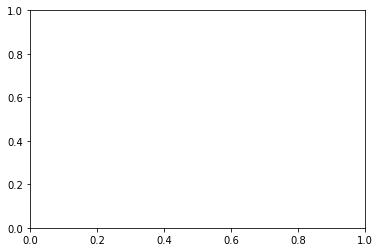

In [28]:
# plt.plot(x_values, loss_first_100_epochs)
# plt.xlabel('Epoch')
# plt.ylabel('Empirical loss')
# plt.yscale('log')
# plt.title('Change in empirical loss in first 100 epochs')
# plt.show()
# plt.plot(x_values, error_first_100_epochs)
# plt.xlabel('Epoch')
# plt.ylabel('Fractional error')
# plt.yscale('log')
# plt.title('Change in fractional error in first 100 epochs')
# plt.show()

In [29]:
with open('loss_record_all.pkl', 'rb') as f:
    b = pickle.load(f)

In [30]:
print(b)

[[-0.006063151425644462, 0.008836361730477537, -0.011146301812169569, -0.03368656954822963, -0.03151519393625441, -0.04274533082470214, -0.0035204755489313165, -0.003265692680515676, -0.002205967216693339, -0.011292049817027226, -0.013287552904450958, -0.01714396317320571, -0.003353737134076002, 0.0006702179858477757, -0.000987359930486177, -0.002179134402763558, -0.0019059653600647446, -0.004022219795715623], [0.9971423196911171, 1.0028324674093905, 0.9940449877366333, 0.984879903688949, 0.9857267151959517, 0.9812180384969946, 0.9984265710063936, 0.9984355147804659, 0.9986933401443411, 0.9948707319474758, 0.9939629820264184, 0.992177974096978, 0.9982333018621894, 1.0003389900998725, 0.9993501494432333, 0.9986111448761367, 0.9987464942606364, 0.9977281735503742], [25, 50, 75, 100, 125, 150]]


## 6. Plotting The Output

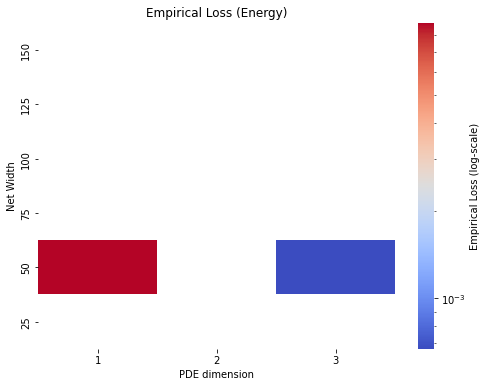

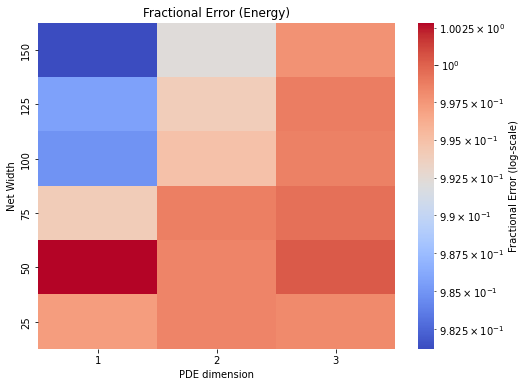

<ipython-input-31-aca75ade6cf8>:29: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


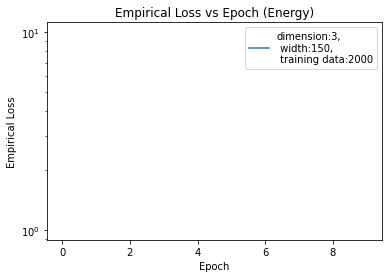

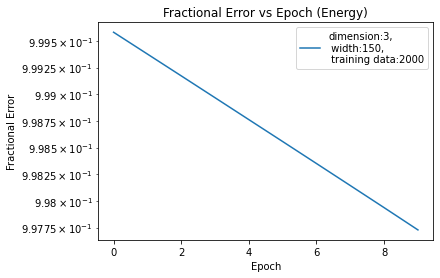

In [31]:
x_axis = dimension_list
y_axis = net_width_list
fig, axee = plt.subplots(figsize=(8, 6))
axee = sns.heatmap(energy_loss_mat_e, xticklabels=x_axis,yticklabels=y_axis, ax=axee, cmap='coolwarm', norm=LogNorm())
axee.invert_yaxis()
axee.set_xlabel("PDE dimension")
axee.set_ylabel("Net Width")
axee.set_title("Empirical Loss (Energy)")
cbar = axee.collections[0].colorbar
cbar.set_label('Empirical Loss (log-scale)')
plt.show()

fig, axef = plt.subplots(figsize=(8, 6))
axef = sns.heatmap(energy_fractional_error, xticklabels=dimension_list, yticklabels=net_width_list, ax=axef, cmap='coolwarm', norm=LogNorm())
plt.gca().invert_yaxis()
axef.set_xlabel("PDE dimension")
axef.set_ylabel("Net Width")
axef.set_title("Fractional Error (Energy)")
cbar = axef.collections[0].colorbar
cbar.set_label('Fractional Error (log-scale)')
plt.show()


label = f'dimension:{input_width},\n width:{layer_width},\n training data:{batch_size}'
plt.plot(range(epoch), loss_epoch, label = label)
plt.title('Empirical Loss vs Epoch (Energy)')
plt.xlabel('Epoch')
plt.ylabel('Empirical Loss')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(range(epoch), error_epoch, label = label)
plt.title('Fractional Error vs Epoch (Energy)')
plt.xlabel('Epoch')
plt.ylabel('Fractional Error')
plt.yscale('log')
plt.legend()
plt.show()

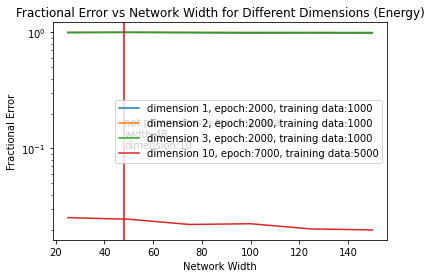

In [32]:
with open('loss_record_all.pkl', 'rb') as f:
    all_data = pickle.load(f)

# Replace the value of new_data with the data want to compare.
new_data = [[-0.047023099875977456, -0.06165234951769611, -0.03233857327001179, -0.030349374442425046, -0.0584814630763615, -0.04492622907573245], [0.02536431356951941, 0.024577069811648058, 0.02214710566289631, 0.022472282732965438, 0.020261843084035395, 0.019880207746692205], [25, 50, 75, 100, 125, 150]]
dimension_list = [1, 2, 3, 10]
net_width_list = all_data[2]
r_value = 0

for dim_idx, dim in enumerate(dimension_list):
    if dim == 10:
        if r_value == 0:
            error_record = new_data[1]
            label = 'dimension 10, epoch:7000, training data:5000'
        else:
            error_record = new_data[1]
            label = f'dimension 10, epoch:7000, training data:5000 \n regularization value: {r_value}'
    else:
        error_record = all_data[1][dim_idx*len(net_width_list):(dim_idx+1)*len(net_width_list)]
        label = f'dimension {dim}, epoch:2000, training data:1000'    
    plt.plot(net_width_list, error_record, label=label)

    # Calculate the number of parameters and training data
    for width_idx, width in enumerate(net_width_list):
        d = dim
        p = 2 * width ** 2 + (4 + d) * width + 1
        if d == 1 or d == 2 or d == 3:
            n = 1000
        else:
            n = 5000

        # Check if p=n for the given width
        if abs(p-n)/n < 1e-5:
            plt.axvline(x=width, color='r')
            plt.text(width, 0.1, f"net parameters = training data\nwidth:{width}\ndimension:{dim}")
            break

        # Check if p=n for a width between the current and next width
        if width_idx < len(net_width_list)-1:
            next_width = net_width_list[width_idx+1]
            next_p = 2 * next_width ** 2 + (4 + d) * next_width + 1
            if p < n < next_p:
                approx_width = np.sqrt((n - (4+d)*width - 1/2) / 2)
                plt.axvline(x=approx_width, color='r')
                plt.text(approx_width, 0.1, f"net parameters = training data\nwidth:{int(approx_width)}\ndimension:{dim}")
                break

plt.legend()
plt.xlabel('Network Width')
plt.ylabel('Fractional Error')
plt.yscale('log')  # set y-axis to log scale
plt.title('Fractional Error vs Network Width for Different Dimensions (Energy)')
plt.show()